In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys

sys.path.append('/content/drive/My Drive/Colab Notebooks/CIDRE')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/edge-table-2013.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/community-label.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

In [ ]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 31385
Number of edges: 8038733
Average degree: 256.13
Max in-degree: 143633
Max out-degree: 228866
Maximum edge weight: 19792
Minimum edge weight: 1


In [ ]:
# Get the group membership
node2com = dict(zip(node_table["journal_id"], node_table["community_id"]))
group_membership = [node2com[node_labels[i]] for i in range(A.shape[0])]

In [ ]:
min_value = min(group_membership)
max_value = max(group_membership)

print("Minimum value:", min_value)
print("Maximum value:", max_value)


Minimum value: 0
Maximum value: 1917


In [ ]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)

In [ ]:
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 16
Number of groups detected: 129


In [ ]:
groups = [group for group in groups if group.get_num_edges()>=50]

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/journal_names.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # Dictionary from MAG journal ID to the journal name

id2label = {k:journalid2label[v] for k, v in node_labels.items()} # This is a dictionary from ID to label, i.e.,

In [ ]:
##choose 3 groups randomly
indices_sampled = np.random.choice(len(groups), 3, replace=False)

groups_sampled = []

for i in indices_sampled:
    groups_sampled.append(groups[i])
    node_ids = groups[i].node_ids
    # Map each node ID to its corresponding label
    node_labels = [id2label[id] for id in node_ids]
    print(node_labels)

['numerical heat transfer part b fundamentals', 'journal of heat transfer transactions of the asme', 'numerical heat transfer part a applications']
['topology and its applications', 'advances in fixed point theory', 'journal of mathematical inequalities', 'international journal of mathematics and mathematical sciences', 'annali dell universita di ferrara', 'journal of inequalities and applications', 'journal of fixed point theory and applications', 'applied mathematics letters', 'hacettepe journal of mathematics and statistics', 'british journal of mathematics & computer science', 'filomat', 'studia scientiarum mathematicarum hungarica', 'fixed point theory and applications', 'journal of mathematical and computational science', 'the journal of nonlinear sciences and applications']
['the north american actuarial journal', 'risk management and insurance review', 'geneva papers on risk and insurance issues and practice', 'journal of risk and insurance']


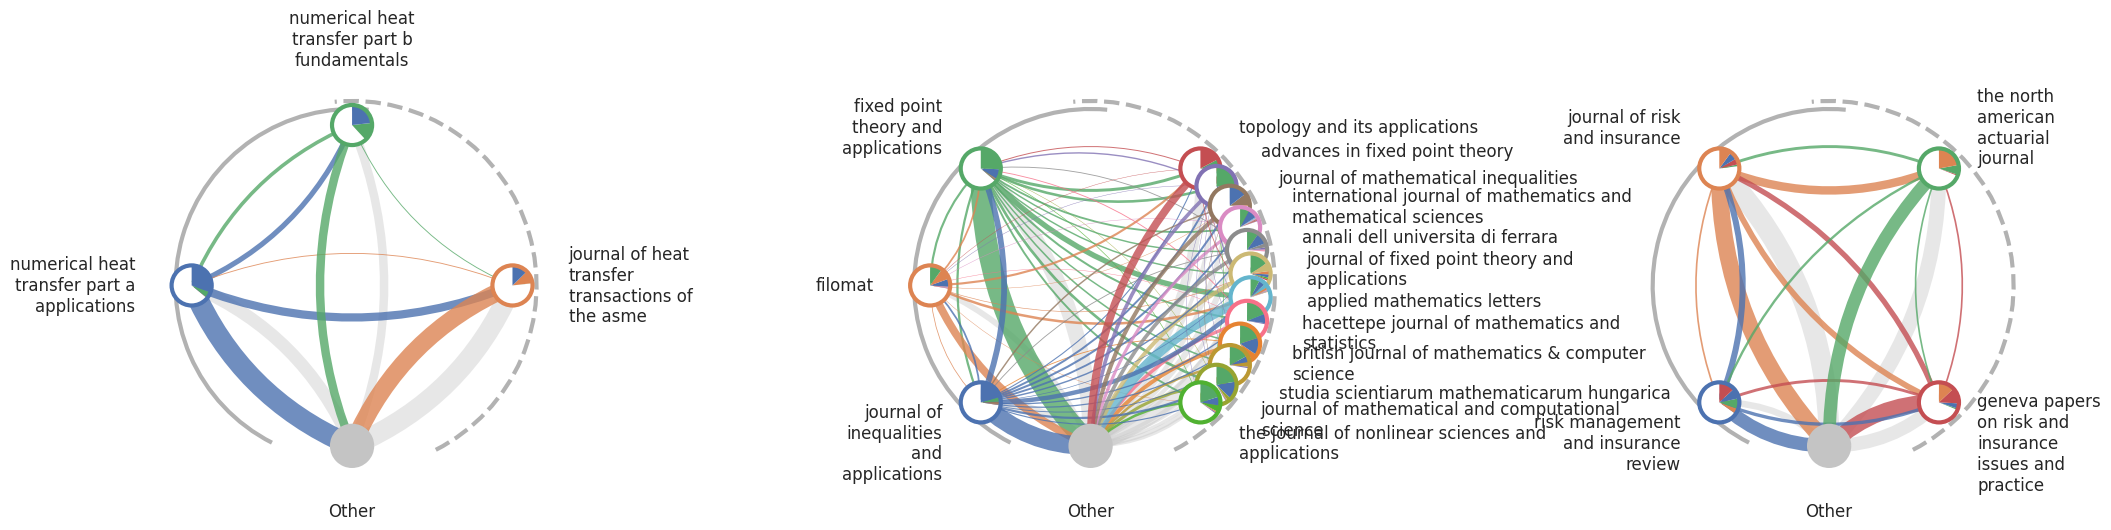

In [ ]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(9 * 3, 5))

for i in range(3):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.7 # Margin between labels and node
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])

In [ ]:
'''
Above is examples of groups.
Below are experiments for different theta value.
'''

'\nAbove is examples of groups.\nBelow are experiments for different theta value.\n'

In [ ]:
suppressed_titles_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/CIDRE/Suppressed-titles-2019-2007.xlsx', sheet_name='by year', header=4)

suppressed_titles_df['Year'] = pd.to_numeric(suppressed_titles_df['Year'], errors='coerce')

suppressed_titles_df = suppressed_titles_df[suppressed_titles_df['Year'] == 2013]

suppressed_journals = set(suppressed_titles_df['Full Title'].str.lower().tolist())

In [ ]:
df_name_set = set(df['name'])

# Count how many items in suppressed_journals are in df['name']
count_in_df = sum(journal in df_name_set for journal in suppressed_journals)

# Get the total number of items in suppressed_journals
total_suppressed_journals = len(suppressed_journals)

print("Number of 2013 suppressed journals in df['name']:", count_in_df)
print("Total number of suppressed journals in 2013:", total_suppressed_journals)
suppressed_journals_filtered = [journal for journal in suppressed_journals if journal in df_name_set]

Number of 2013 suppressed journals in df['name']: 34
Total number of suppressed journals in 2013: 38


In [ ]:
all_in_df_set = all(journal in df_name_set for journal in suppressed_journals_filtered)

print("All items in suppressed_journals_filtered are in df['name']:", all_in_df_set)
len(suppressed_journals_filtered)

All items in suppressed_journals_filtered are in df['name']: True


34

In [ ]:
theta_values = np.logspace(np.log10(0.01), np.log10(0.15), num=10)

# Initialize the cidre algorithm
alg = cidre.Cidre(group_membership=group_membership, alpha=0.01, min_edge_weight=10)

# Results storage
results = []

for theta in theta_values:
    groups = alg.detect(A, threshold=theta)
    filtered_groups = [group for group in groups if group.get_num_edges() >= 10]

    group_count = 0
    journal_count = 0
    total_journals = 0
    community_sets = set()  # Store unique communities for each group

    for group in filtered_groups:
        node_ids = group.node_ids
        node_labels = [id2label[id] for id in node_ids]
        suppressed_found = False
        for id in node_ids:
            community_id = group_membership[id]
            community_sets.add(community_id)

        for label in node_labels:
            total_journals += 1
            if label in suppressed_journals_filtered:
                journal_count += 1
                suppressed_found = True

        if suppressed_found:
            group_count += 1

    # Storing results for this theta
    results.append({
        'theta': theta,
        'largest_group': np.max([group.size() for group in filtered_groups]),
        'suppressed_percentage': journal_count / 34,
        'journal_count': journal_count,
        'total_journals': total_journals,
        'group_count': group_count,
        'total_groups': len(filtered_groups),
        'unique_communities': community_sets
    })

Plot saved as 'theta_analysis_plots.png'.


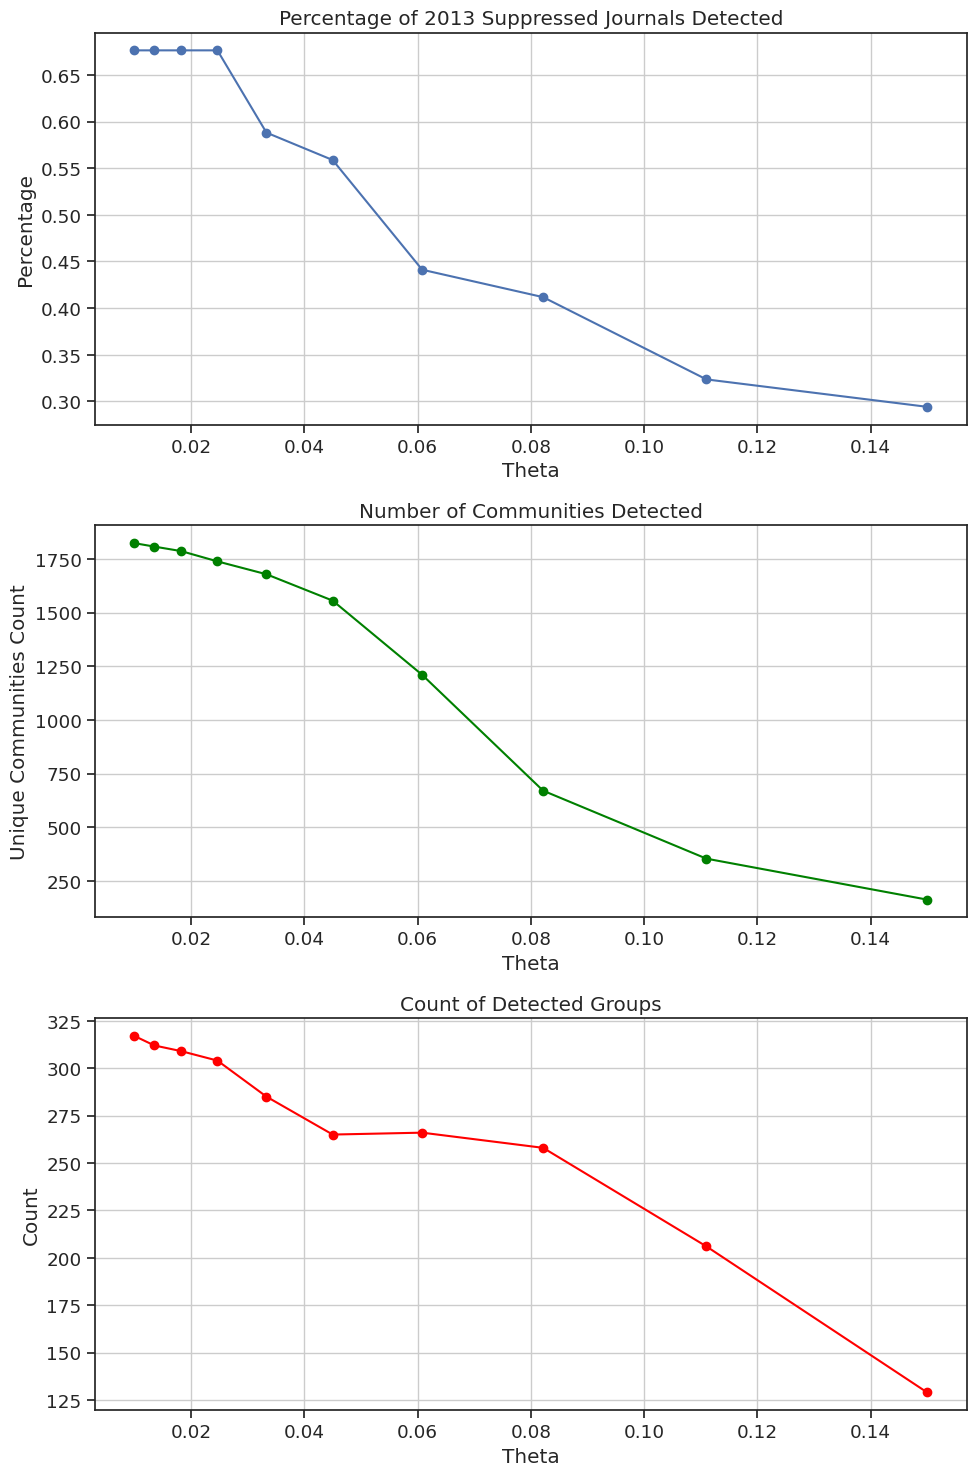

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results' is already filled with data from the previous step
# Convert results into a DataFrame for easier manipulation
df_results = pd.DataFrame(results)
df_results['unique_communities'] = df_results['unique_communities'].apply(len)

# Setting up the plot with multiple subplots for different metrics
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plotting Percentage of 2013 suppressed journals detected
axs[0].plot(df_results['theta'], df_results['suppressed_percentage'], marker='o', linestyle='-')
axs[0].set_title('Percentage of 2013 Suppressed Journals Detected')
axs[0].set_xlabel('Theta')
axs[0].set_ylabel('Percentage')
axs[0].grid(True)

# Plotting Number of unique community sets
axs[1].plot(df_results['theta'], df_results['unique_communities'], marker='o', color='green', linestyle='-')
axs[1].set_title('Number of Communities Detected')
axs[1].set_xlabel('Theta')
axs[1].set_ylabel('Unique Communities Count')
axs[1].grid(True)

# Plotting Count of detected groups
axs[2].plot(df_results['theta'], df_results['total_groups'], marker='o', color='red', linestyle='-')
axs[2].set_title('Count of Detected Groups')
axs[2].set_xlabel('Theta')
axs[2].set_ylabel('Count')
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file
plt.savefig('theta_analysis_plots.png', dpi=300)

# Optionally, you can display the plot as well
# plt.show()

# Indicate that the plot has been saved
print("Plot saved as 'theta_analysis_plots.png'.")

In [ ]:
df_results

,theta,largest_group,suppressed_percentage,journal_count,total_journals,group_count,total_groups,unique_communities
0,0.010000,6598,0.676471,23,7333,5,317,1824
1,0.013511,6511,0.676471,23,7238,5,312,1808
2,0.018254,6375,0.676471,23,7095,5,309,1787
3,0.024662,6081,0.676471,23,6790,5,304,1739
4,0.033320,5650,0.588235,20,6316,4,285,1679
5,0.045018,4843,0.558824,19,5458,4,265,1556
6,0.060822,3189,0.441176,15,3842,5,266,1210
7,0.082175,1100,0.411765,14,1966,7,258,670
8,0.111023,180,0.323529,11,893,6,206,353
9,0.150000,16,0.294118,10,394,5,129,162
